# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn

import scienceplots
plt.style.use(['science','no-latex'])

# Query the current default figure size
current_fig_size = plt.rcParams["figure.figsize"]
print(f"Current default figure size: {current_fig_size}")

# Define a scalar factor
scalar_factor = 1.5

# Multiply the current figure size by the scalar factor
new_fig_size = [size * scalar_factor for size in current_fig_size]

# Set the new default figure size
plt.rcParams["figure.figsize"] = new_fig_size

print(f"New default figure size: {new_fig_size}")


import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn import datasets, decomposition

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [3]:
from polcanet import LinearDecoder, PolcaNet, PolcaNetLoss
from polcanet.example_aencoders import ConvEncoder, VGG, DenseEncoder, ConvDecoder

In [4]:
import polcanet.polcanet_reports as report

In [5]:
import utils as ut
import random

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

exp = ut.ExperimentInfoHandler(
    name="cifar10_dataset",
    description="POLCA-Net on cifar10 dataset",
    random_seed=random_seed,
)
report.set_save_fig(True)
report.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving Images: {report.get_save_fig()}, saving in path: {report.get_save_path()}")

Saving Images: True, saving in path: /data/deploy/polcanet/examples/notebooks/cifar10_dataset


### Load dataset

In [6]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Load CIFAR-10 dataset
cifar_trainset = CIFAR10(root="data/CIFAR10", train=True, download=True, transform=None)
cifar_testset = CIFAR10(root="data/CIFAR10", train=False, download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
train_dataset = cifar_trainset.data / 255.0  #.reshape(-1, 32, 32, 3) / 255.0 
eval_dataset = cifar_testset.data / 255.0 # .reshape(-1, 32, 32, 3) / 255.0   

y = np.array(cifar_trainset.targets)
y_test = np.array(cifar_trainset.targets)

X = np.array(train_dataset, dtype=np.float32)
X = np.squeeze(X)

X_test = np.array(eval_dataset, dtype=np.float32)
X_test = np.squeeze(X_test)

if X.ndim==4:
    X = np.moveaxis(X, -1, 1)
    X_test = np.moveaxis(X_test, -1, 1)
    

train_dataset.shape, eval_dataset.shape, X.shape, X_test.shape, y.shape, y_test.shape, X[0].min(),X[0].max()

((50000, 32, 32, 3),
 (10000, 32, 32, 3),
 (50000, 3, 32, 32),
 (10000, 3, 32, 32),
 (50000,),
 (50000,),
 0.0,
 1.0)

cifar10 train dataset images:


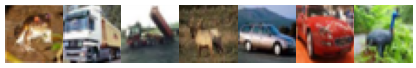

cifar10 dataset images:


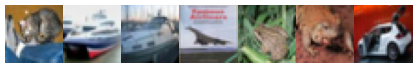

In [17]:
report.set_fig_prefix("train")
print("cifar10 train dataset images:")
ut.plot_train_images(X, "", n=7)
report.set_fig_prefix("test")
print("cifar10 dataset images:")
ut.plot_train_images(X_test, "", n=7)

### Fit standard sklearn PCA

In [18]:
32*3*3

288

In [ ]:
n_components = 32 * 3 * 3
fig, axs = plt.subplots(1,1,sharex=True, sharey=True,layout='constrained')
pca = ut.get_pca(X,n_components=n_components,title="PCA on cifar10",ax=axs)
Xpca = pca.transform(np.squeeze(X.reshape(X.shape[0], -1)))
plt.show()

### Fit POLCANet

In [ ]:
N = X[0].shape[-1]
M = X[0].shape[-2]
X[0].shape, N, M

In [ ]:
act_fn = torch.nn.SiLU
input_dim = X[0].shape
latent_dim = pca.n_components
assert N == input_dim[-1], "input_dim[-1] should match first matrix dimension N"
assert M == input_dim[-2], "input_dim[-2] should match second matrix dimension M"

from torchvision import models
from polcanet.example_aencoders import ConvEncoder, ConvDecoder
encoder = ConvEncoder(
    input_channels=3,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=8,
    growth_factor=2,
    num_layers=3,
    act_fn=act_fn,
)

# encoder = VGG('VGG11', latent_dim=latent_dim, act_fn=act_fn)


# # Load a pre-trained ResNet model and modify it for CIFAR-10
# encoder = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Load a pre-trained ResNet18 model
# num_ftrs = encoder.fc.in_features
# encoder.fc = torch.nn.Linear(num_ftrs, latent_dim)  # Modify the last layer for 10 classes of CIFAR-10


decoder = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=256,
    num_layers=2,
    # act_fn=act_fn,
    bias=False,
)

decoder = ConvDecoder(
    latent_dim=latent_dim,
    output_channels=3,
    conv_dim=2,
    num_layers=3,
    initial_channels=8,
    growth_factor=2,
    act_fn=act_fn,
    output_act_fn=torch.nn.Sigmoid,
    final_output_size=(32, 32),
)


model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    alpha=0.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=0,  # variance reduction loss
    device=device,
    center=False,
    factor_scale=False,
)
report.save_text(str(model), "model.txt")
model

In [ ]:
# train_dataloader = DataLoader(X, batch_size=2*512, shuffle=True,num_workers=0)
# test_dataloader = DataLoader(X_test, batch_size=2*512, shuffle=True, num_workers=0)

In [ ]:
model.to(device)
model.train_model(data=X,batch_size=2*256, num_epochs=1000, report_freq=10, lr=1e-3)

In [ ]:
model.train_model(data=X,batch_size=2*256, num_epochs=1000, report_freq=10, lr=1e-4)

In [ ]:
model.train_model(data=X, batch_size=2*256, num_epochs=1000, report_freq=10, lr=1e-5)

## Evaluate results

## Evaluate results

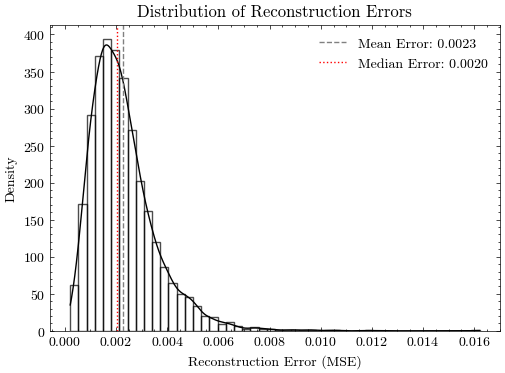

Mean Reconstruction Error: 0.0023
Median Reconstruction Error: 0.0020
Min Reconstruction Error: 0.0002
Max Reconstruction Error: 0.0162


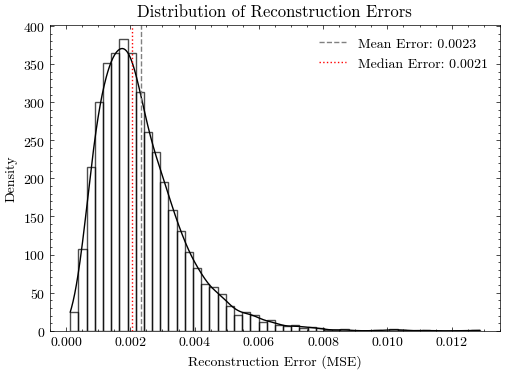

Mean Reconstruction Error: 0.0023
Median Reconstruction Error: 0.0021
Min Reconstruction Error: 0.0001
Max Reconstruction Error: 0.0129


In [354]:
report.set_fig_prefix("train")
report.analyze_reconstruction_error(model, X[:5000])
report.set_fig_prefix("test")
report.analyze_reconstruction_error(model, X_test[:5000])

In [355]:
latents, reconstructed = model.predict(X)

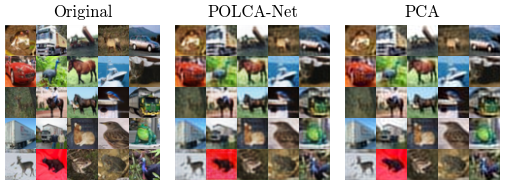

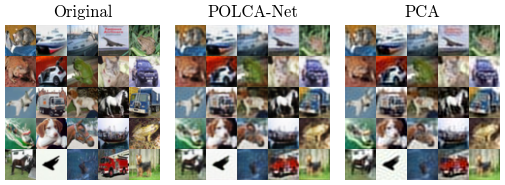

In [356]:
# Assuming images are properly defined as before
images = X[0:25]
report.set_fig_prefix("train")
ut.plot_reconstruction_comparison(model,pca,images,nrow=5)
images = X_test[0:25]
report.set_fig_prefix("test")
ut.plot_reconstruction_comparison(model,pca,images,nrow=5)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0007
    - Max cosine similarity: 0.9855
    - Min cosine similarity: -0.9847
    


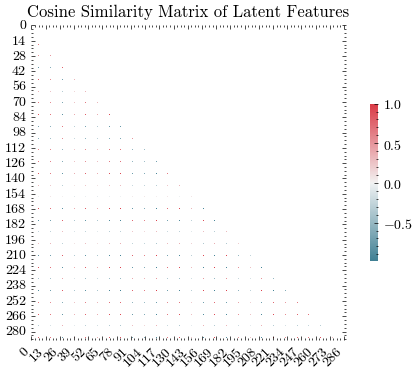

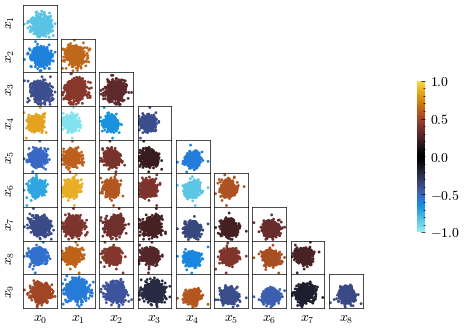


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0006
    - Max cosine similarity: 0.9877
    - Min cosine similarity: -0.9854
    


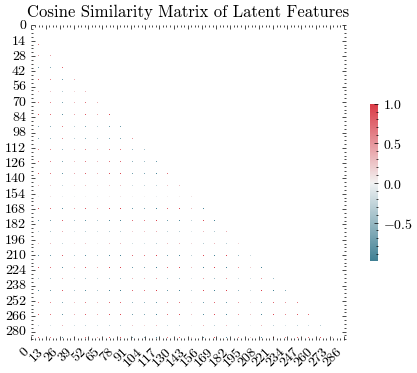

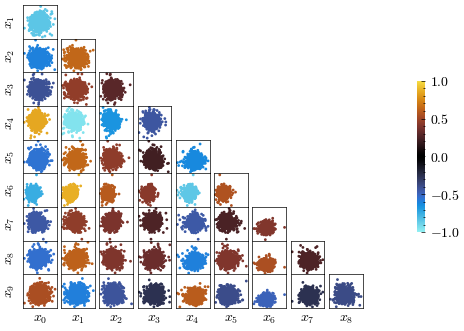

In [357]:
report.set_fig_prefix("train")
report.orthogonality_test_analysis(model, X)
report.set_fig_prefix("test")
report.orthogonality_test_analysis(model, X_test)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 144.8965
    - Variance fit to exponential distribution (sum of squared differences):
     0.4597
    


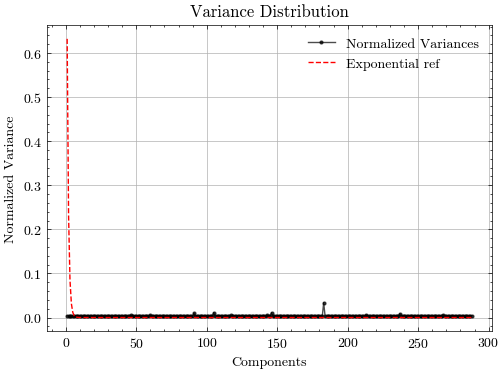

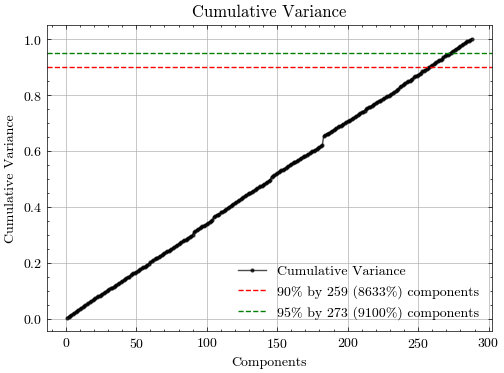

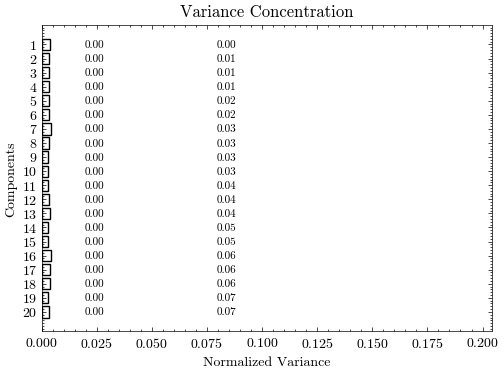


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 145.3866
    - Variance fit to exponential distribution (sum of squared differences):
     0.4602
    


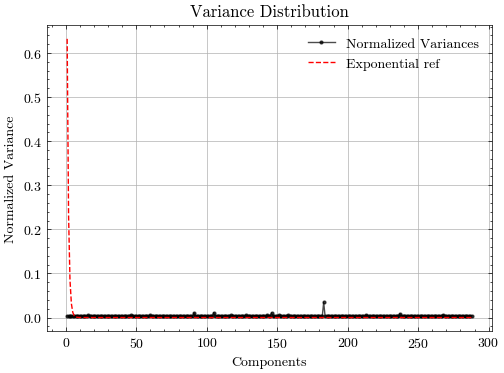

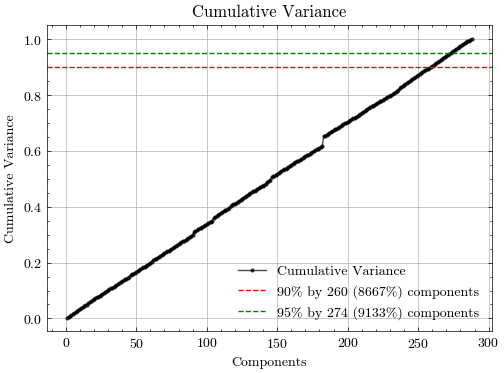

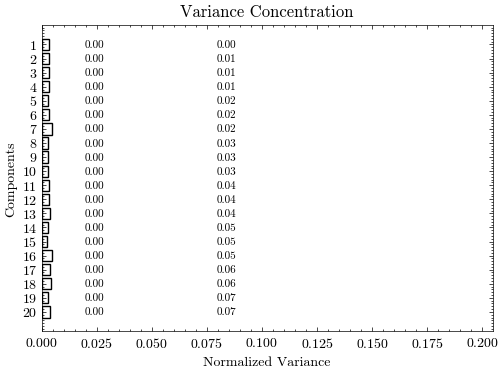

In [358]:
report.set_fig_prefix("train")
report.variance_test_analysis(model, X)
report.set_fig_prefix("test")
report.variance_test_analysis(model, X_test)

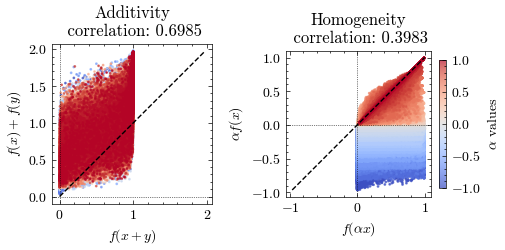

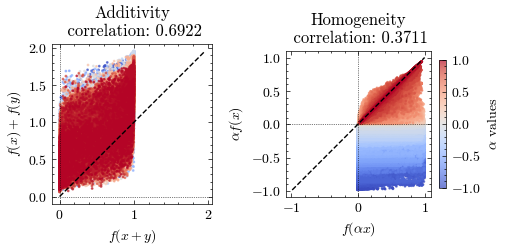

In [359]:
report.set_fig_prefix("train")
report.linearity_tests_analysis(model, X,num_samples=100)
report.set_fig_prefix("test")
report.linearity_tests_analysis(model, X_test,num_samples=100)

## Test Classification with two components on PCA vs POLCA Net

In [ ]:
# _ = ut.make_classification_report(model, pca, X, y)

(35000, 288) (15000, 288)
(35000, 288) (15000, 288)


/data/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

In [ ]:
experiment_data = {
    "cifar10" : (X_test,model,pca),   
}
df_image_metrics = ut.image_metrics_table(experiment_data)